# Análises do MVP – Indicadores Hospitalares

## Contexto e objetivo
Este notebook apresenta exemplos de consultas analíticas suportadas pelo Data Warehouse desenvolvido no MVP, demonstrando a aplicação do modelo dimensional na extração de indicadores hospitalares a partir da camada Gold. As análises ilustram o uso direto da tabela fato de internações e de suas dimensões associadas na resposta aos objetivos centrais do projeto.

## Premissas e qualidade dos dados
**A análise de qualidade dos dados foi conduzida previamente durante a construção da camada Gold**, onde foram verificadas a consistência temporal dos encontros, a integridade referencial entre fatos e dimensões, a presença de valores ausentes em atributos críticos e a plausibilidade das métricas derivadas (tempo de permanência, óbito intra-hospitalar e readmissão em até 30 dias). As inconsistências identificadas foram discutidas e tratadas nessa etapa, garantindo que os dados consumidos neste notebook analítico estejam adequados para a produção dos indicadores apresentados a seguir.

## Escopo analítico
As análises incluem:

- Mortalidade hospitalar (geral e estratificada por tempo, diagnóstico e perfil demográfico)

- Tempo de permanência hospitalar (LOS) com medidas robustas (média, mediana e quartis) e estratificações

- Readmissão em até 30 dias após a alta (incluindo definição de altas elegíveis) e segmentações por dimensões

## Imports e configuração

In [0]:
# Imports 
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.ticker as mtick

sns.set()

# Definição do catálogo e schema padrão
spark.sql("USE CATALOG mvp_engenharia_de_dados")
spark.sql("USE gold")


DataFrame[]

## Carregamento das tabelas Gold


In [0]:
# Carregamento das tabelas da camada Gold
fato = spark.table("fato_internacao")
dim_pac = spark.table("dim_paciente")
dim_diag = spark.table("dim_diagnostico")
dim_tempo = spark.table("dim_tempo")

# Exibir schemas
print("=== Schema: FATO_INTERNACAO ===")
fato.printSchema()

print("\n=== Schema: DIM_PACIENTE ===")
dim_pac.printSchema()

print("\n=== Schema: DIM_DIAGNOSTICO ===")
dim_diag.printSchema()

print("\n=== Schema: DIM_TEMPO ===")
dim_tempo.printSchema()


=== Schema: FATO_INTERNACAO ===
root
 |-- internacao_sk: long (nullable = true)
 |-- encounter_id: string (nullable = true)
 |-- patient_id: string (nullable = true)
 |-- paciente_sk: long (nullable = true)
 |-- diagnostico_sk: long (nullable = true)
 |-- data_admissao_sk: long (nullable = true)
 |-- data_alta_sk: long (nullable = true)
 |-- data_admissao: date (nullable = true)
 |-- data_alta: date (nullable = true)
 |-- idade_admissao: long (nullable = true)
 |-- faixa_etaria_admissao: string (nullable = true)
 |-- los_dias: integer (nullable = true)
 |-- obito_internacao: boolean (nullable = true)
 |-- readmissao_30d: boolean (nullable = true)


=== Schema: DIM_PACIENTE ===
root
 |-- paciente_sk: long (nullable = true)
 |-- patient_id: string (nullable = true)
 |-- sexo: string (nullable = true)
 |-- data_nascimento: date (nullable = true)
 |-- data_obito: date (nullable = true)
 |-- raca: string (nullable = true)
 |-- etnia: string (nullable = true)


=== Schema: DIM_DIAGNOSTICO ==

## Construção da base analítica (internações + dimensões)
Nesta etapa é construída a base analítica que será utilizada em todas as consultas deste notebook. A tabela fato de internações (`fato_internacao`) é integrada às dimensões do Data Warehouse para disponibilizar, em um único DataFrame, os atributos necessários às análises

In [0]:
# ====================================================
# Base analítica (comum para todos os desfechos)
# ====================================================
base_analitica = (
    fato.drop("data_admissao", "data_alta")
    .join(dim_pac.select("paciente_sk", "sexo", "raca", "etnia"), "paciente_sk", "left")
    .join(dim_diag.select("diagnostico_sk", "reasondescription"), "diagnostico_sk", "left")
    .join(
        dim_tempo.select("tempo_sk", "ano", "mes", "dia"),
        F.col("data_admissao_sk") == dim_tempo["tempo_sk"],
        "left"
    )
    .withColumnRenamed("reasondescription", "diagnostico")
    .withColumn("obito_int", F.col("obito_internacao").cast("int"))
    .withColumn("readm_int", F.col("readmissao_30d").cast("int"))
)


## Análises: Mortalidade hospitalar

Nesta seção é estimada a mortalidade intra-hospitalar, definida como a proporção de internações com óbito durante o período do encontro (óbitos na internação / total de internações). Além do valor agregado, o indicador é estratificado por tempo, diagnóstico principal e perfil demográfico, permitindo avaliar variações ao longo do período e diferenças associadas ao *case-mix*.

- **Mortalidade geral:** taxa global no período analisado.
- **Mortalidade por ano:** evolução anual da taxa (ano de admissão).
- **Letalidade por diagnóstico:** mortalidade estratificada por diagnóstico principal (com n mínimo para estabilidade).
- **Mortalidade por perfil demográfico:** estratificação por faixa etária, sexo e raça



Tabela 1 — Mortalidade hospitalar (geral)


internacoes,obitos,mortalidade_pct
6339,101,1.59



Tabela 2 — Mortalidade hospitalar por ano de admissão


ano,internacoes,obitos,mortalidade_pct
2000,141,5,3.55
2001,139,1,0.72
2002,149,5,3.36
2003,140,2,1.43
2004,175,1,0.57
2005,200,2,1.0
2006,163,0,0.0
2007,159,4,2.52
2008,172,6,3.49
2009,205,1,0.49



Figura 1 — Mortalidade hospitalar por ano de admissão


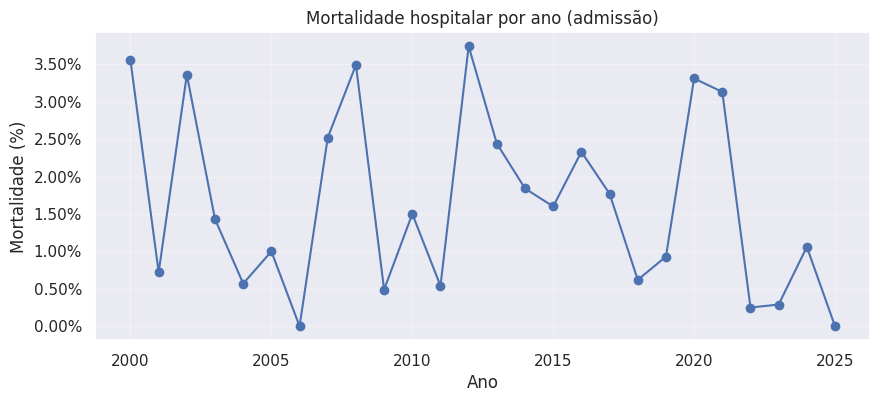


Tabela 3 — Letalidade por diagnóstico (n ≥ 30)


diagnostico,internacoes,obitos,letalidade_pct
Chronic congestive heart failure (disorder),272,55,20.22
Disease caused by severe acute respiratory syndrome coronavirus 2 (disorder),188,24,12.77
Acute ST segment elevation myocardial infarction (disorder),92,5,5.43
Abnormal findings diagnostic imaging heart+coronary circulat (finding),179,6,3.35
Acute non-ST segment elevation myocardial infarction (disorder),159,2,1.26
Non-small cell carcinoma of lung TNM stage 1 (disorder),1785,6,0.34
History of coronary artery bypass grafting (situation),607,2,0.33
Dependent drug abuse (disorder),1033,0,0.0
Sterilization requested (situation),476,0,0.0
Sleep disorder (disorder),264,0,0.0



Figura 2 — Top 10 diagnósticos por letalidade (n ≥ 30)


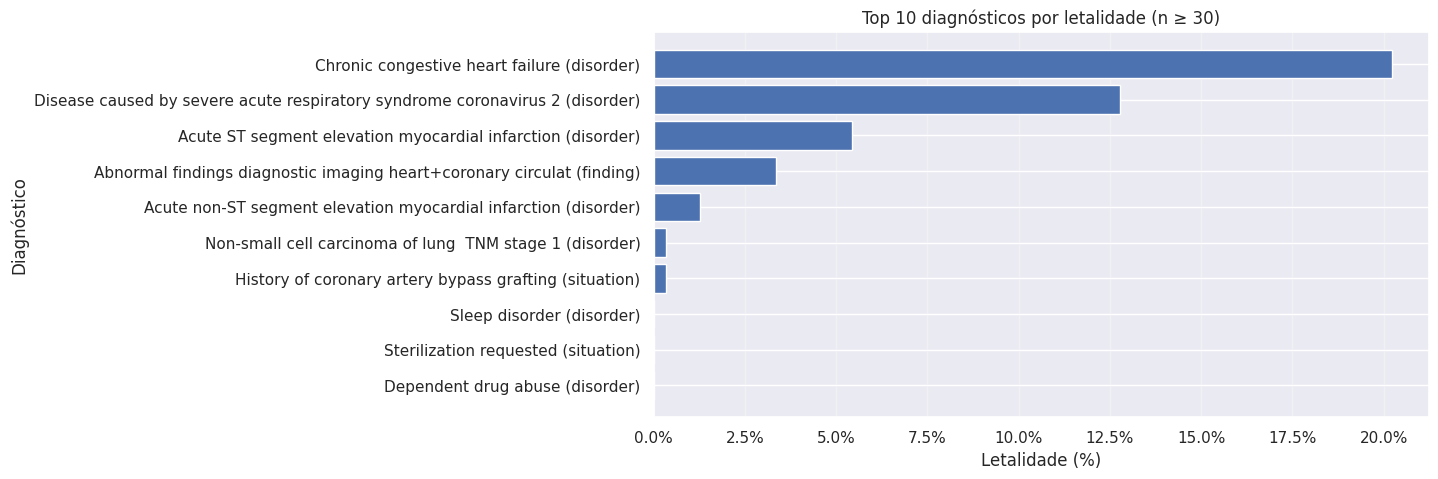


Tabela 4 — Mortalidade por faixa etária na admissão


faixa_etaria_admissao,internacoes,obitos,mortalidade_pct
0-17,133,0,0.0
18-39,1109,2,0.18
40-64,3073,53,1.72
65-79,1757,31,1.76
80+,267,15,5.62



Tabela 5 — Mortalidade por sexo


sexo,internacoes,obitos,mortalidade_pct
F,2571,45,1.75
M,3768,56,1.49



Tabela 6 — Mortalidade por raça


raca,internacoes,obitos,mortalidade_pct
white,5283,83,1.57
black,567,9,1.59
asian,347,6,1.73
native,59,2,3.39
hawaiian,44,1,2.27
other,39,0,0.0


In [0]:
# ====================================================
# 1) Mortalidade hospitalar 
# ====================================================


# Base analítica (internações + dimensões)
base_mort = base_analitica

# ------------------------------
# 1.1 Mortalidade geral
# ------------------------------
mort_geral = (
    base_mort
    .agg(
        F.count("*").alias("internacoes"),
        F.sum("obito_int").alias("obitos")
    )
    .withColumn("mortalidade_pct", F.round(F.col("obitos") / F.col("internacoes") * 100, 2))
)

print("\nTabela 1 — Mortalidade hospitalar (geral)")
display(mort_geral)

# ------------------------------
# 1.2 Mortalidade por ano (admissão)
# ------------------------------
mort_ano = (
    base_mort
    .groupBy("ano")
    .agg(
        F.count("*").alias("internacoes"),
        F.sum("obito_int").alias("obitos"),
        F.round(F.avg("obito_int") * 100, 2).alias("mortalidade_pct")
    )
    .orderBy("ano")
)

print("\nTabela 2 — Mortalidade hospitalar por ano de admissão")
display(mort_ano)

mort_ano_pd = mort_ano.toPandas()

print("\nFigura 1 — Mortalidade hospitalar por ano de admissão")
plt.figure(figsize=(10, 4))
plt.plot(mort_ano_pd["ano"], mort_ano_pd["mortalidade_pct"], marker="o")
plt.title("Mortalidade hospitalar por ano (admissão)")
plt.xlabel("Ano")
plt.ylabel("Mortalidade (%)")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.grid(True, alpha=0.3)
plt.show()

# ------------------------------
# 1.3 Letalidade por diagnóstico (com n mínimo)
# ------------------------------
N_MIN = 30  # ajuste se necessário

mort_diag = (
    base_mort
    .groupBy("diagnostico")
    .agg(
        F.count("*").alias("internacoes"),
        F.sum("obito_int").alias("obitos"),
        F.round(F.avg("obito_int") * 100, 2).alias("letalidade_pct")
    )
    .filter(F.col("internacoes") >= F.lit(N_MIN))
    .orderBy(F.col("letalidade_pct").desc(), F.col("internacoes").desc())
)

print(f"\nTabela 3 — Letalidade por diagnóstico (n ≥ {N_MIN})")
display(mort_diag)

top10_letal = mort_diag.limit(10).toPandas().sort_values("letalidade_pct", ascending=True)

print(f"\nFigura 2 — Top 10 diagnósticos por letalidade (n ≥ {N_MIN})")
plt.figure(figsize=(10, 5))
plt.barh(top10_letal["diagnostico"], top10_letal["letalidade_pct"])
plt.title(f"Top 10 diagnósticos por letalidade (n ≥ {N_MIN})")
plt.xlabel("Letalidade (%)")
plt.ylabel("Diagnóstico")
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter())
plt.grid(True, axis="x", alpha=0.3)
plt.show()

# ------------------------------
# 1.4 Mortalidade por faixa etária / sexo / raça
# ------------------------------
mort_fx = (
    base_mort
    .groupBy("faixa_etaria_admissao")
    .agg(
        F.count("*").alias("internacoes"),
        F.sum("obito_int").alias("obitos"),
        F.round(F.avg("obito_int") * 100, 2).alias("mortalidade_pct")
    )
    .orderBy("faixa_etaria_admissao")
)

print("\nTabela 4 — Mortalidade por faixa etária na admissão")
display(mort_fx)

mort_sexo = (
    base_mort
    .groupBy("sexo")
    .agg(
        F.count("*").alias("internacoes"),
        F.sum("obito_int").alias("obitos"),
        F.round(F.avg("obito_int") * 100, 2).alias("mortalidade_pct")
    )
    .orderBy("sexo")
)

print("\nTabela 5 — Mortalidade por sexo")
display(mort_sexo)

mort_raca = (
    base_mort
    .groupBy("raca")
    .agg(
        F.count("*").alias("internacoes"),
        F.sum("obito_int").alias("obitos"),
        F.round(F.avg("obito_int") * 100, 2).alias("mortalidade_pct")
    )
    .orderBy(F.col("internacoes").desc())
)

print("\nTabela 6 — Mortalidade por raça")
display(mort_raca)


### Discussão: Mortalidade hospitalar

A mortalidade hospitalar foi estimada na unidade de análise do MVP (internações), a partir do indicador binário obito_int na tabela fato, definido quando o óbito do paciente ocorre durante o intervalo da internação. A base analítica integra internações às dimensões de tempo, diagnóstico e perfil demográfico, permitindo estratificações conforme o objetivo do projeto.

No período analisado, ocorreram 6.339 internações e 101 óbitos intra-hospitalares, resultando em mortalidade geral de 1,59%. Esse indicador consolida o desfecho em nível de internação e demonstra a capacidade do DW em produzir métricas hospitalares reprodutíveis.

Na análise temporal, observa-se oscilação anual da mortalidade (aprox. 0–4%), compatível com variações do denominador (n de internações por ano) e do case-mix anual. Portanto, tendências anuais devem ser interpretadas considerando o volume de internações e a composição de diagnósticos em cada período.

A estratificação por diagnóstico (com n ≥ 30) evidencia heterogeneidade de risco: insuficiência cardíaca congestiva (20,22%), COVID-19 (12,77%) e Infarto agudo do miocárdio (STEMI) (5,43%) figuram entre as maiores letalidades, reforçando que a mortalidade agregada é fortemente influenciada pelo case-mix. Como o “diagnóstico” deriva do motivo principal registrado no encounter, a interpretação é de associação ao motivo da internação, não de causalidade.

Por perfil demográfico, há gradiente etário consistente (80+ = 5,62% vs 0–17 = 0%), enquanto diferenças por sexo foram pequenas (F 1,75% vs M 1,49%). Em raça/etnia, algumas categorias têm baixa contagem, tornando a taxa instável e limitando comparações.

Em síntese, o MVP responde à pergunta de mortalidade hospitalar e permite exploração por tempo, diagnóstico e demografia, com limitações principais relacionadas à estabilidade em subgrupos pequenos e à natureza do diagnóstico como “motivo principal” do encontro.

## Análises: Tempo de permanência hospitalar (LOS)

Nesta seção é analisado o **tempo de permanência hospitalar (Length of Stay – LOS)**, definido como o número de dias entre admissão e alta da internação. O indicador é apresentado por medidas robustas de tendência central e dispersão (média, mediana e quartis) e estratificado por tempo, diagnóstico principal e perfil demográfico, permitindo caracterizar padrões de utilização de leitos e variações associadas ao *case-mix*.

- **LOS geral:** média, mediana e quartis no período analisado.
- **LOS por ano:** variação anual do LOS (ano de admissão).
- **LOS por diagnóstico:** LOS estratificado por diagnóstico principal (com n mínimo para estabilidade).
- **LOS por perfil demográfico:** estratificação por faixa etária, sexo e raça.



Tabela 8 — LOS geral (média, mediana e quartis)


internacoes,los_medio_dias,los_mediano_dias,los_p25_dias,los_p75_dias
6339,4.94,4,1,7



Tabela 9 — LOS por ano de admissão


ano,internacoes,los_medio_dias,los_mediano_dias
2000,141,4.27,4
2001,139,5.04,4
2002,149,5.09,4
2003,140,4.62,4
2004,175,4.45,4
2005,200,4.83,4
2006,163,5.66,5
2007,159,4.76,4
2008,172,4.75,4
2009,205,5.08,4



Figura 3 — LOS mediano por ano de admissão


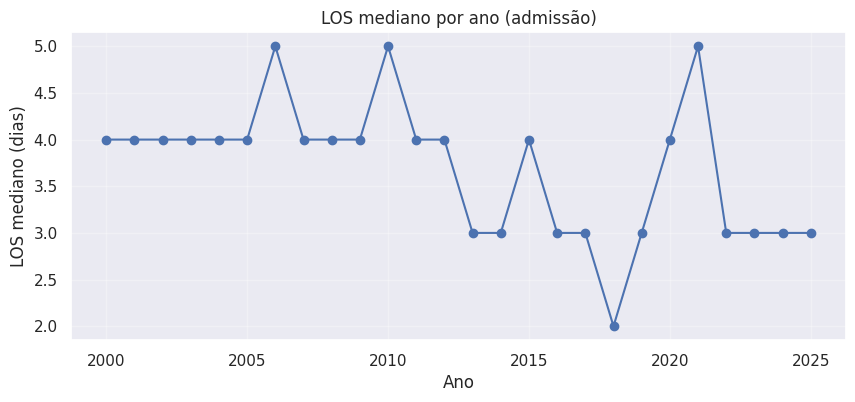


Tabela 10 — LOS por diagnóstico (n ≥ 30)


diagnostico,internacoes,los_medio_dias,los_mediano_dias
Awaiting transplantation of bone marrow (situation),41,15.63,12
Disease caused by severe acute respiratory syndrome coronavirus 2 (disorder),188,9.66,10
Non-small cell carcinoma of lung TNM stage 1 (disorder),1785,6.44,6
Primary small cell malignant neoplasm of lung TNM stage 1 (disorder),238,6.83,6
Dependent drug abuse (disorder),1033,7.58,5
Malignant neoplasm of colon (disorder),38,7.32,5
Chronic congestive heart failure (disorder),272,5.52,4
Overlapping malignant neoplasm of colon (disorder),42,4.71,4
Awaiting transplantation of kidney (situation),186,5.09,3
Appendicitis (disorder),186,3.05,3



Figura 4 — Top 10 diagnósticos por LOS mediano (n ≥ 30)


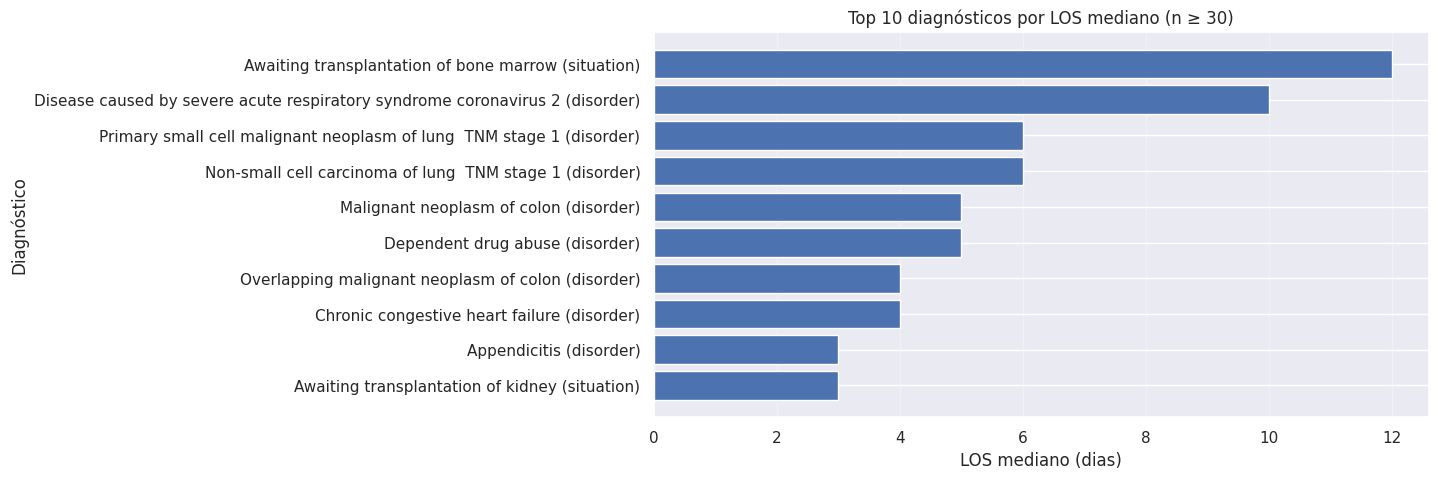


Tabela 11 — LOS por faixa etária na admissão


faixa_etaria_admissao,internacoes,los_medio_dias,los_mediano_dias
0-17,133,4.36,3
18-39,1109,3.53,1
40-64,3073,5.29,4
65-79,1757,5.29,4
80+,267,4.92,4



Tabela 12 — LOS por sexo


sexo,internacoes,los_medio_dias,los_mediano_dias
F,2571,4.46,2
M,3768,5.27,4



Tabela 13 — LOS por raça


raca,internacoes,los_medio_dias,los_mediano_dias
white,5283,5.0,4
black,567,4.57,3
asian,347,4.44,3
native,59,5.92,5
hawaiian,44,4.2,2
other,39,6.1,2


In [0]:
# ====================================================
# 2) Tempo de permanência hospitalar (LOS)
# ====================================================

# Base analítica (internações + dimensões)
base_los_ok  = base_analitica.filter(F.col("los_dias").isNotNull() & (F.col("los_dias") >= 0))

# ------------------------------
# 2.1 LOS geral (média, mediana, P25, P75)
# ------------------------------
los_geral = (
    base_los_ok
    .agg(
        F.count("*").alias("internacoes"),
        F.round(F.avg("los_dias"), 2).alias("los_medio_dias"),
        F.expr("percentile_approx(los_dias, 0.50)").alias("los_mediano_dias"),
        F.expr("percentile_approx(los_dias, 0.25)").alias("los_p25_dias"),
        F.expr("percentile_approx(los_dias, 0.75)").alias("los_p75_dias")
    )
)

print("\nTabela 8 — LOS geral (média, mediana e quartis)")
display(los_geral)

# ------------------------------
# 2.2 LOS por ano (admissão)
# ------------------------------
los_ano = (
    base_los_ok
    .groupBy("ano")
    .agg(
        F.count("*").alias("internacoes"),
        F.round(F.avg("los_dias"), 2).alias("los_medio_dias"),
        F.expr("percentile_approx(los_dias, 0.50)").alias("los_mediano_dias")
    )
    .orderBy("ano")
)

print("\nTabela 9 — LOS por ano de admissão")
display(los_ano)

los_ano_pd = los_ano.toPandas()

print("\nFigura 3 — LOS mediano por ano de admissão")
plt.figure(figsize=(10, 4))
plt.plot(los_ano_pd["ano"], los_ano_pd["los_mediano_dias"], marker="o")
plt.title("LOS mediano por ano (admissão)")
plt.xlabel("Ano")
plt.ylabel("LOS mediano (dias)")
plt.grid(True, alpha=0.3)
plt.show()

# ------------------------------
# 2.3 LOS por diagnóstico (Top 10 por LOS mediano, com n mínimo)
# ------------------------------
N_MIN = 30  # pode reutilizar o mesmo limiar

los_diag = (
    base_los_ok
    .groupBy("diagnostico")
    .agg(
        F.count("*").alias("internacoes"),
        F.round(F.avg("los_dias"), 2).alias("los_medio_dias"),
        F.expr("percentile_approx(los_dias, 0.50)").alias("los_mediano_dias")
    )
    .filter(F.col("internacoes") >= F.lit(N_MIN))
    .orderBy(F.col("los_mediano_dias").desc(), F.col("internacoes").desc())
)

print(f"\nTabela 10 — LOS por diagnóstico (n ≥ {N_MIN})")
display(los_diag)

top10_los = los_diag.limit(10).toPandas().sort_values("los_mediano_dias", ascending=True)

print(f"\nFigura 4 — Top 10 diagnósticos por LOS mediano (n ≥ {N_MIN})")
plt.figure(figsize=(10, 5))
plt.barh(top10_los["diagnostico"], top10_los["los_mediano_dias"])
plt.title(f"Top 10 diagnósticos por LOS mediano (n ≥ {N_MIN})")
plt.xlabel("LOS mediano (dias)")
plt.ylabel("Diagnóstico")
plt.grid(True, axis="x", alpha=0.3)
plt.show()

# ------------------------------
# 2.4 LOS por perfil demográfico (faixa etária, sexo, raça)
# ------------------------------
los_fx = (
    base_los_ok
    .groupBy("faixa_etaria_admissao")
    .agg(
        F.count("*").alias("internacoes"),
        F.round(F.avg("los_dias"), 2).alias("los_medio_dias"),
        F.expr("percentile_approx(los_dias, 0.50)").alias("los_mediano_dias")
    )
    .orderBy("faixa_etaria_admissao")
)

print("\nTabela 11 — LOS por faixa etária na admissão")
display(los_fx)

los_sexo = (
    base_los_ok
    .groupBy("sexo")
    .agg(
        F.count("*").alias("internacoes"),
        F.round(F.avg("los_dias"), 2).alias("los_medio_dias"),
        F.expr("percentile_approx(los_dias, 0.50)").alias("los_mediano_dias")
    )
    .orderBy("sexo")
)

print("\nTabela 12 — LOS por sexo")
display(los_sexo)

los_raca = (
    base_los_ok
    .groupBy("raca")
    .agg(
        F.count("*").alias("internacoes"),
        F.round(F.avg("los_dias"), 2).alias("los_medio_dias"),
        F.expr("percentile_approx(los_dias, 0.50)").alias("los_mediano_dias")
    )
    .orderBy(F.col("internacoes").desc())
)

print("\nTabela 13 — LOS por raça")
display(los_raca)


### Discussão: Tempo de permanência hospitalar (LOS)

O LOS foi calculado em dias (los_dias) por internação, após exclusão de valores nulos e negativos. No agregado, o LOS médio foi 4,94 dias, com mediana de 4 dias e quartis P25 = 1 e P75 = 7 (Tabela 8). A diferença entre média e mediana indica assimetria à direita; portanto, mediana e quartis são mais apropriados para comparação operacional.

Por ano de admissão, o LOS mediano oscilou em torno de 3–5 dias (Tabela 9; Figura 3), sem tendência clara, sugerindo influência do volume anual e do case-mix. Por diagnóstico (n ≥ 30), há heterogeneidade relevante, com LOS mediano maior em condições de maior complexidade (p. ex., “awaiting transplantation”, COVID-19, neoplasias) (Tabela 10; Figura 4).

Nas estratificações demográficas (faixa etária, sexo e raça), as diferenças foram em geral moderadas (Tabelas 11–13) e devem ser interpretadas à luz da composição de diagnósticos; para raça, categorias com baixa contagem tornam as estimativas menos estáveis.

Em síntese, o MVP gera LOS consolidado e segmentável por tempo, diagnóstico e demografia, atendendo ao objetivo analítico proposto.

%md
## Análises: Readmissão em até 30 dias

Nesta seção é estimada a taxa de readmissão em até 30 dias, definida como a proporção de internações que apresentam uma nova admissão do mesmo paciente em até 30 dias após a alta. O indicador é reportado no agregado e, para maior consistência conceitual, também considerando altas elegíveis (exclui óbito na internação). As análises incluem estratificações por tempo, diagnóstico principal e perfil demográfico.

- **Readmissão geral:** taxa no período (todas as internações vs. altas elegíveis).
- **Readmissão por ano:** variação anual da taxa (ano de admissão, usando altas elegíveis).
- **Readmissão por diagnóstico:** taxa estratificada por diagnóstico principal (com n mínimo para estabilidade).
- **Readmissão por perfil demográfico:** estratificação por faixa etária, sexo e raça.



Tabela 14 — Readmissão em 30 dias (geral)


internacoes,readmissoes_30d,readmissao_30d_pct
6339,919,14.5



Tabela 15 — Readmissão em 30 dias (altas elegíveis: exclui óbito na internação)


altas_elegiveis,readmissoes_30d,readmissao_30d_pct
6238,919,14.73



Tabela 16 — Readmissão em 30 dias por ano de admissão (altas elegíveis)


ano,altas_elegiveis,readmissoes_30d,readmissao_30d_pct
2000,136,22,16.18
2001,138,24,17.39
2002,144,17,11.81
2003,138,19,13.77
2004,174,41,23.56
2005,198,49,24.75
2006,163,41,25.15
2007,155,36,23.23
2008,166,46,27.71
2009,204,50,24.51



Figura 5 — Readmissão em 30 dias por ano de admissão (altas elegíveis)


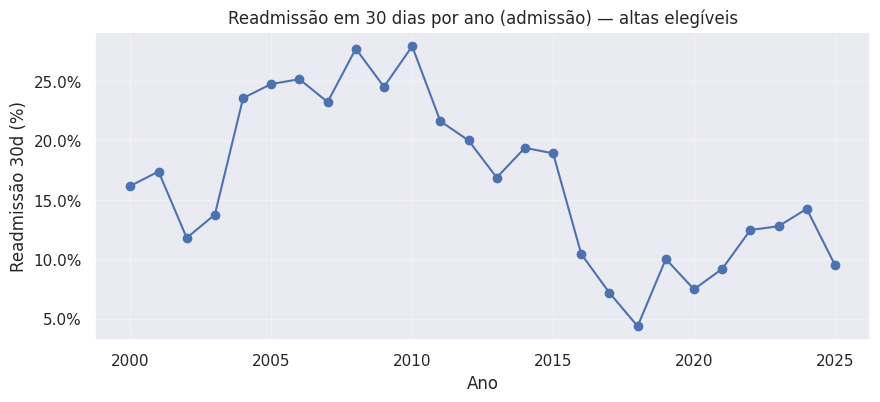


Tabela 17 — Readmissão em 30 dias por diagnóstico (n ≥ 30, altas elegíveis)


diagnostico,altas_elegiveis,readmissoes_30d,readmissao_30d_pct
Primary small cell malignant neoplasm of lung TNM stage 1 (disorder),238,213,89.5
Non-small cell carcinoma of lung TNM stage 1 (disorder),1779,591,33.22
Aortic valve regurgitation (disorder),30,6,20.0
Aortic valve stenosis (disorder),43,8,18.6
Abnormal findings diagnostic imaging heart+coronary circulat (finding),173,30,17.34
Chronic congestive heart failure (disorder),217,15,6.91
History of coronary artery bypass grafting (situation),605,40,6.61
Awaiting transplantation of bone marrow (situation),41,1,2.44
Awaiting transplantation of kidney (situation),186,3,1.61
History of aortic valve replacement (situation),64,1,1.56



Figura 6 — Top 10 diagnósticos por readmissão em 30 dias (n ≥ 30, altas elegíveis)


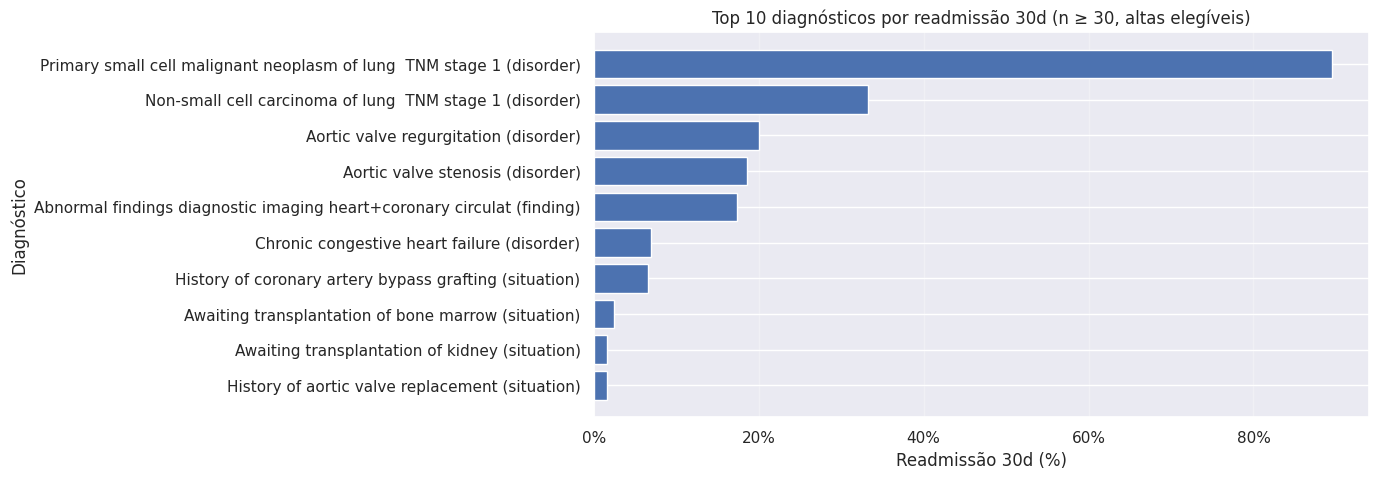


Tabela 18 — Readmissão em 30 dias por faixa etária na admissão (altas elegíveis)


faixa_etaria_admissao,altas_elegiveis,readmissoes_30d,readmissao_30d_pct
0-17,133,0,0.0
18-39,1107,4,0.36
40-64,3020,486,16.09
65-79,1726,395,22.89
80+,252,34,13.49



Tabela 19 — Readmissão em 30 dias por sexo (altas elegíveis)


sexo,altas_elegiveis,readmissoes_30d,readmissao_30d_pct
F,2526,151,5.98
M,3712,768,20.69



Tabela 20 — Readmissão em 30 dias por raça (altas elegíveis)


raca,altas_elegiveis,readmissoes_30d,readmissao_30d_pct
white,5200,780,15.0
black,558,63,11.29
asian,341,63,18.48
native,57,12,21.05
hawaiian,43,1,2.33
other,39,0,0.0


In [0]:
# ====================================================
# 3) Readmissão em até 30 dias após a alta
# ====================================================

# Observação:  readmissao_30d foi derivada na camada Gold
# (um boolean por internação). Para as análises, adicionei uma regra de "altas elegíveis",
# com um filtro que exclui óbito na internação.

base_readm = base_analitica.withColumn("readm_int", F.col("readmissao_30d").cast("int"))

# altas elegíveis: exclui óbito na internação
base_readm_elig = base_readm.filter(F.col("obito_int") == 0)

# ------------------------------
# 3.1 Readmissão geral (e elegível)
# ------------------------------
readm_geral = (
    base_readm
    .agg(
        F.count("*").alias("internacoes"),
        F.sum("readm_int").alias("readmissoes_30d")
    )
    .withColumn("readmissao_30d_pct", F.round(F.col("readmissoes_30d") / F.col("internacoes") * 100, 2))
)

print("\nTabela 14 — Readmissão em 30 dias (geral)")
display(readm_geral)

readm_elig = (
    base_readm_elig
    .agg(
        F.count("*").alias("altas_elegiveis"),
        F.sum("readm_int").alias("readmissoes_30d")
    )
    .withColumn("readmissao_30d_pct", F.round(F.col("readmissoes_30d") / F.col("altas_elegiveis") * 100, 2))
)

print("\nTabela 15 — Readmissão em 30 dias (altas elegíveis: exclui óbito na internação)")
display(readm_elig)

# ------------------------------
# 3.2 Readmissão por ano (admissão) — consistente com o padrão do MVP
#     (se preferir por ano de alta, podemos trocar para data_alta_sk e outra join)
# ------------------------------
readm_ano = (
    base_readm_elig
    .groupBy("ano")
    .agg(
        F.count("*").alias("altas_elegiveis"),
        F.sum("readm_int").alias("readmissoes_30d"),
        F.round(F.avg("readm_int") * 100, 2).alias("readmissao_30d_pct")
    )
    .orderBy("ano")
)

print("\nTabela 16 — Readmissão em 30 dias por ano de admissão (altas elegíveis)")
display(readm_ano)

readm_ano_pd = readm_ano.toPandas()

print("\nFigura 5 — Readmissão em 30 dias por ano de admissão (altas elegíveis)")
plt.figure(figsize=(10, 4))
plt.plot(readm_ano_pd["ano"], readm_ano_pd["readmissao_30d_pct"], marker="o")
plt.title("Readmissão em 30 dias por ano (admissão) — altas elegíveis")
plt.xlabel("Ano")
plt.ylabel("Readmissão 30d (%)")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.grid(True, alpha=0.3)
plt.show()

# ------------------------------
# 3.3 Readmissão por diagnóstico (com n mínimo)
# ------------------------------
N_MIN = 30

readm_diag = (
    base_readm_elig
    .groupBy("diagnostico")
    .agg(
        F.count("*").alias("altas_elegiveis"),
        F.sum("readm_int").alias("readmissoes_30d"),
        F.round(F.avg("readm_int") * 100, 2).alias("readmissao_30d_pct")
    )
    .filter(F.col("altas_elegiveis") >= F.lit(N_MIN))
    .orderBy(F.col("readmissao_30d_pct").desc(), F.col("altas_elegiveis").desc())
)

print(f"\nTabela 17 — Readmissão em 30 dias por diagnóstico (n ≥ {N_MIN}, altas elegíveis)")
display(readm_diag)

top10_readm = readm_diag.limit(10).toPandas().sort_values("readmissao_30d_pct", ascending=True)

print(f"\nFigura 6 — Top 10 diagnósticos por readmissão em 30 dias (n ≥ {N_MIN}, altas elegíveis)")
plt.figure(figsize=(10, 5))
plt.barh(top10_readm["diagnostico"], top10_readm["readmissao_30d_pct"])
plt.title(f"Top 10 diagnósticos por readmissão 30d (n ≥ {N_MIN}, altas elegíveis)")
plt.xlabel("Readmissão 30d (%)")
plt.ylabel("Diagnóstico")
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter())
plt.grid(True, axis="x", alpha=0.3)
plt.show()

# ------------------------------
# 3.4 Readmissão por perfil demográfico (faixa etária, sexo, raça)
# ------------------------------
readm_fx = (
    base_readm_elig
    .groupBy("faixa_etaria_admissao")
    .agg(
        F.count("*").alias("altas_elegiveis"),
        F.sum("readm_int").alias("readmissoes_30d"),
        F.round(F.avg("readm_int") * 100, 2).alias("readmissao_30d_pct")
    )
    .orderBy("faixa_etaria_admissao")
)

print("\nTabela 18 — Readmissão em 30 dias por faixa etária na admissão (altas elegíveis)")
display(readm_fx)

readm_sexo = (
    base_readm_elig
    .groupBy("sexo")
    .agg(
        F.count("*").alias("altas_elegiveis"),
        F.sum("readm_int").alias("readmissoes_30d"),
        F.round(F.avg("readm_int") * 100, 2).alias("readmissao_30d_pct")
    )
    .orderBy("sexo")
)

print("\nTabela 19 — Readmissão em 30 dias por sexo (altas elegíveis)")
display(readm_sexo)

readm_raca = (
    base_readm_elig
    .groupBy("raca")
    .agg(
        F.count("*").alias("altas_elegiveis"),
        F.sum("readm_int").alias("readmissoes_30d"),
        F.round(F.avg("readm_int") * 100, 2).alias("readmissao_30d_pct")
    )
    .orderBy(F.col("altas_elegiveis").desc())
)

print("\nTabela 20 — Readmissão em 30 dias por raça (altas elegíveis)")
display(readm_raca)


### Discussão: Readmissão em até 30 dias
A readmissão em 30 dias (readmissao_30d, Gold) foi calculada por internação como nova admissão do mesmo paciente em até 30 dias após a alta, adotando como denominador altas elegíveis (exclui óbito na internação). No agregado, a taxa foi 14,5% (919/6339; Tabela 14) e 14,73% entre altas elegíveis (919/6238; Tabela 15), indicando impacto mínimo do óbito no denominador.

Por ano (altas elegíveis), houve variação relevante (Tabela 16; Figura 5), plausivelmente influenciada por volume anual e case-mix. Por diagnóstico (n ≥ 30), observa-se heterogeneidade acentuada, com alguns motivos apresentando taxas muito elevadas (Tabela 17; Figura 6), o que deve ser interpretado com cautela por depender do “motivo principal” do encounter e do comportamento do dado sintético.

Nas estratificações demográficas (Tabelas 18–20), as diferenças podem refletir composição de diagnósticos e complexidade; categorias com baixa contagem têm estimativas menos estáveis. Em síntese, o MVP entrega o indicador de readmissão 30 dias e permite segmentação por tempo, diagnóstico e demografia.

## Discussão: Síntese da solução do problema

O MVP demonstrou que o pipeline de ingestão e transformação, aliado ao Data Warehouse em esquema estrela, organiza dados clínicos originalmente dispersos em uma estrutura analítica única, consistente e reutilizável, com a internação como unidade de análise. A partir da tabela fato integrada às dimensões de tempo, diagnóstico e perfil do paciente, foi possível calcular e explorar os indicadores hospitalares propostos.

A mortalidade foi calculada de forma consolidada e segmentável (tempo, diagnóstico e faixa etária). O LOS foi descrito por mediana e quartis, evidenciando assimetria e variação por diagnóstico. A readmissão em 30 dias foi estimada com definição operacional e denominador de altas elegíveis, permitindo estratificação por tempo, diagnóstico e demografia. Em conjunto, as análises evidenciaram a influência do case-mix, e o volume/ocupação complementou a leitura operacional ao descrever a dinâmica das internações ao longo do tempo.

É importante ressaltar que o dado sintético pode conter artefatos que não refletem realidades epidemiológicas, o que limita a generalização dos resultados. No entanto, o pipeline conseguiu organizar dados dispersos e gerar indicadores úteis, demonstrando a funcionalidade do DW, mas com a cautela de que a precisão dos resultados pode ser afetada pela natureza dos dados.

Assim, o MVP cumpriu o objetivo de gerar indicadores consolidados e exploráveis por múltiplas dimensões. As principais limitações foram a instabilidade em estratos pequenos e as definições do dado de origem ( diagnóstico como motivo principal), aspectos mitigáveis com enriquecimento semântico e regras adicionais de qualidade.